Loading and Preparing the Data

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
df = pd.read_csv('Mental_health_dataset.csv', on_bad_lines='skip')

print(df.columns)

Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


In [ ]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

# Ensure consistent column names (if necessary)
df.columns = df.columns.str.strip()  # Remove any leading/trailing spaces
print(df.columns)  # Check the columns after cleaning


Index(['statement', 'status'], dtype='object')


Text Preprocessing

In [ ]:
def clean_text(text):
    # Ensure the input is a string (handle non-string cases like NaN)
    if not isinstance(text, str):
        text = str(text)

    # Proceed with the original cleaning steps
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert text to lowercase
    return text


In [ ]:
df['cleaned_statement'] = df['statement'].apply(clean_text)


In [ ]:
# Fill missing values with an empty string or a placeholder
df['statement'] = df['statement'].fillna('')

# Apply the clean_text function
df['cleaned_statement'] = df['statement'].apply(clean_text)


In [ ]:
print(df.head())

                                           statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

                                   cleaned_statement  
0                                         oh my gosh  
1  trouble sleeping confused mind restless heart ...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shifted my focus to something else but im ...  
4  im restless and restless its been a month now ...  


Tokenization and Padding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the 'cleaned_statement' column
tokenizer = Tokenizer(num_words=5000)  # Limit to top 5000 words
tokenizer.fit_on_texts(df['cleaned_statement'])

# Convert text to sequences of integers
X = tokenizer.texts_to_sequences(df['cleaned_statement'])

# Pad sequences to ensure they all have the same length
X_padded = pad_sequences(X, padding='post', maxlen=100)  # Adjust maxlen based on your data

# Check the shape of the padded data
print(X_padded.shape)


(53043, 100)


Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'status' column
y = label_encoder.fit_transform(df['status'])

# Check the encoded labels
print(y[:10])  # Print the first 10 encoded labels


[0 0 0 0 0 0 0 0 0 0]


Splitting Data into Training and Testing Sets

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Check the shapes of the split data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(42434, 100) (10609, 100) (42434,) (10609,)


Building the Neural Network Models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


In [ ]:
# Model 1: RNN LSTM with additional layers
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=128, input_length=100))  # Adjust dimensions as needed
model_lstm.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model_lstm.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))  # Additional LSTM layer
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(7, activation='softmax'))  # 7 classes for mental health status
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Model 2: Bidirectional LSTM RNN with additional layers
model_bidirectional_lstm = Sequential()
model_bidirectional_lstm.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_bidirectional_lstm.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model_bidirectional_lstm.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))  # Additional Bidirectional LSTM layer
model_bidirectional_lstm.add(Dense(64, activation='relu'))
model_bidirectional_lstm.add(Dropout(0.3))
model_bidirectional_lstm.add(Dense(7, activation='softmax'))
model_bidirectional_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Training the Models

In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/10
1327/1327 [==============================] - 197s 145ms/step - loss: 1.2314 - accuracy: 0.5085 - val_loss: 0.9731 - val_accuracy: 0.5953 - lr: 0.0010
Epoch 2/10
1327/1327 [==============================] - 191s 144ms/step - loss: 0.8981 - accuracy: 0.6128 - val_loss: 0.8434 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 3/10
1327/1327 [==============================] - 190s 144ms/step - loss: 0.7749 - accuracy: 0.6921 - val_loss: 0.8138 - val_accuracy: 0.6955 - lr: 0.0010
Epoch 4/10
1327/1327 [==============================] - 190s 143ms/step - loss: 0.6841 - accuracy: 0.7316 - val_loss: 0.7242 - val_accuracy: 0.7151 - lr: 0.0010
Epoch 5/10
1327/1327 [==============================] - 191s 144ms/step - loss: 0.6035 - accuracy: 0.7708 - val_loss: 0.6682 - val_accuracy: 0.7342 - lr: 0.0010
Epoch 6/10
1327/1327 [==============================] - 190s 143ms/step - loss: 0.5399 - accuracy: 0.7945 - val_loss: 0.6377 - val_accuracy: 0.7575 - lr: 0.0010
Epoch 7/10
1327/1327 [============

In [ ]:
history_lstm64 = model_lstm.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/10
664/664 [==============================] - 110s 166ms/step - loss: 0.4075 - accuracy: 0.8496 - val_loss: 0.6494 - val_accuracy: 0.7704 - lr: 2.0000e-04
Epoch 2/10
664/664 [==============================] - 110s 166ms/step - loss: 0.3839 - accuracy: 0.8578 - val_loss: 0.6609 - val_accuracy: 0.7739 - lr: 2.0000e-04
Epoch 3/10
664/664 [==============================] - 110s 165ms/step - loss: 0.3726 - accuracy: 0.8631 - val_loss: 0.6794 - val_accuracy: 0.7725 - lr: 2.0000e-04
Epoch 4/10
664/664 [==============================] - 110s 165ms/step - loss: 0.3550 - accuracy: 0.8706 - val_loss: 0.6849 - val_accuracy: 0.7722 - lr: 4.0000e-05


In [ ]:
history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/10
1327/1327 [==============================] - 302s 220ms/step - loss: 0.9864 - accuracy: 0.5966 - val_loss: 0.8037 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 2/10
1327/1327 [==============================] - 289s 218ms/step - loss: 0.7976 - accuracy: 0.6789 - val_loss: 0.7738 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 3/10
1327/1327 [==============================] - 291s 219ms/step - loss: 0.7041 - accuracy: 0.7217 - val_loss: 0.6912 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 4/10
1327/1327 [==============================] - 290s 219ms/step - loss: 0.6070 - accuracy: 0.7656 - val_loss: 0.6391 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 5/10
1327/1327 [==============================] - 291s 219ms/step - loss: 0.5502 - accuracy: 0.7862 - val_loss: 0.6147 - val_accuracy: 0.7588 - lr: 0.0010
Epoch 6/10
1327/1327 [==============================] - 289s 218ms/step - loss: 0.5101 - accuracy: 0.8038 - val_loss: 0.6210 - val_accuracy: 0.7643 - lr: 0.0010
Epoch 7/10
1327/1327 [============

In [ ]:
history_bidirectional_lstm64 = model_bidirectional_lstm.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/10
664/664 [==============================] - 143s 215ms/step - loss: 0.4653 - accuracy: 0.8221 - val_loss: 0.6252 - val_accuracy: 0.7637 - lr: 2.0000e-04
Epoch 2/10
664/664 [==============================] - 143s 215ms/step - loss: 0.4458 - accuracy: 0.8287 - val_loss: 0.6261 - val_accuracy: 0.7629 - lr: 2.0000e-04
Epoch 3/10
664/664 [==============================] - 143s 215ms/step - loss: 0.4300 - accuracy: 0.8349 - val_loss: 0.6294 - val_accuracy: 0.7648 - lr: 2.0000e-04
Epoch 4/10
664/664 [==============================] - 143s 215ms/step - loss: 0.4122 - accuracy: 0.8428 - val_loss: 0.6395 - val_accuracy: 0.7651 - lr: 4.0000e-05


Evaluating the Models

In [ ]:
# Evaluate all models on the test data
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
test_loss_lstm64, test_acc_lstm64 = model_lstm.evaluate(X_test, y_test, verbose=0)
test_loss_bidirectional_lstm, test_acc_bidirectional_lstm = model_bidirectional_lstm.evaluate(X_test, y_test, verbose=0)
test_loss_bidirectional_lstm64, test_acc_bidirectional_lstm64 = model_bidirectional_lstm.evaluate(X_test, y_test, verbose=0)

# Print results
print("RNN LSTM Model (Batch Size 32) Test Accuracy: {:.4f}, Test Loss: {:.4f}".format(test_acc_lstm, test_loss_lstm))
print("RNN LSTM Model (Batch Size 64) Test Accuracy: {:.4f}, Test Loss: {:.4f}".format(test_acc_lstm64, test_loss_lstm64))
print("Bidirectional LSTM Model (Batch Size 32) Test Accuracy: {:.4f}, Test Loss: {:.4f}".format(test_acc_bidirectional_lstm, test_loss_bidirectional_lstm))
print("Bidirectional LSTM Model (Batch Size 64) Test Accuracy: {:.4f}, Test Loss: {:.4f}".format(test_acc_bidirectional_lstm64, test_loss_bidirectional_lstm64))

RNN LSTM Model (Batch Size 32) Test Accuracy: 0.7704, Test Loss: 0.6494
RNN LSTM Model (Batch Size 64) Test Accuracy: 0.7704, Test Loss: 0.6494
Bidirectional LSTM Model (Batch Size 32) Test Accuracy: 0.7637, Test Loss: 0.6252
Bidirectional LSTM Model (Batch Size 64) Test Accuracy: 0.7637, Test Loss: 0.6252


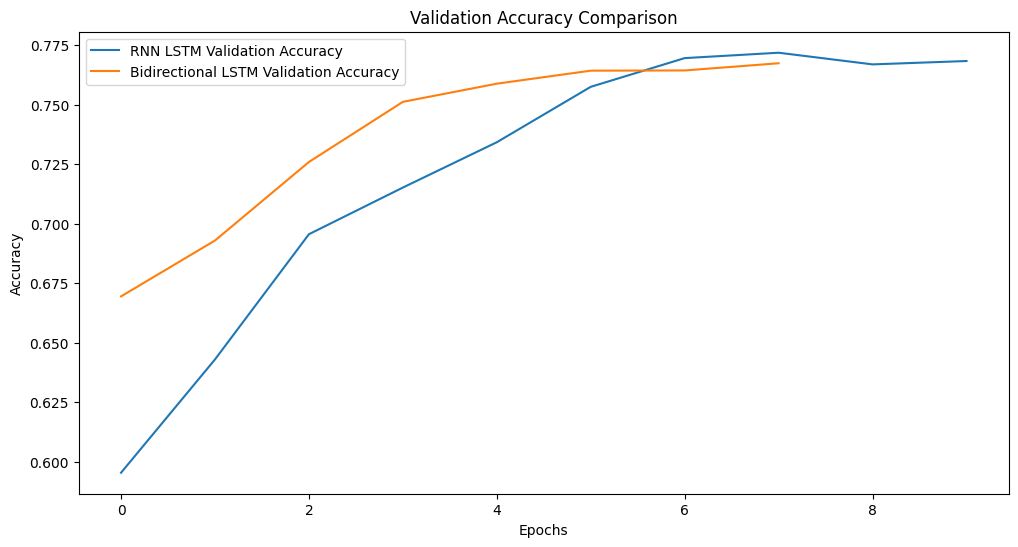

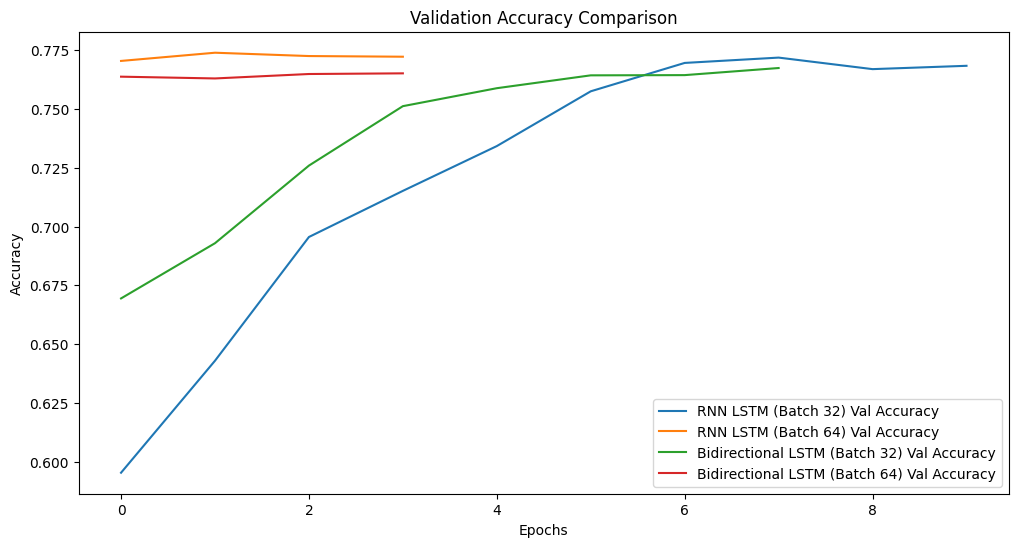

In [ ]:
# Plotting accuracy and loss for comparison
# Accuracy comparison
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['val_accuracy'], label='RNN LSTM Validation Accuracy')
plt.plot(history_bidirectional_lstm.history['val_accuracy'], label='Bidirectional LSTM Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()# Plotting validation accuracy comparison
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['val_accuracy'], label='RNN LSTM (Batch 32) Val Accuracy')
plt.plot(history_lstm64.history['val_accuracy'], label='RNN LSTM (Batch 64) Val Accuracy')
plt.plot(history_bidirectional_lstm.history['val_accuracy'], label='Bidirectional LSTM (Batch 32) Val Accuracy')
plt.plot(history_bidirectional_lstm64.history['val_accuracy'], label='Bidirectional LSTM (Batch 64) Val Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

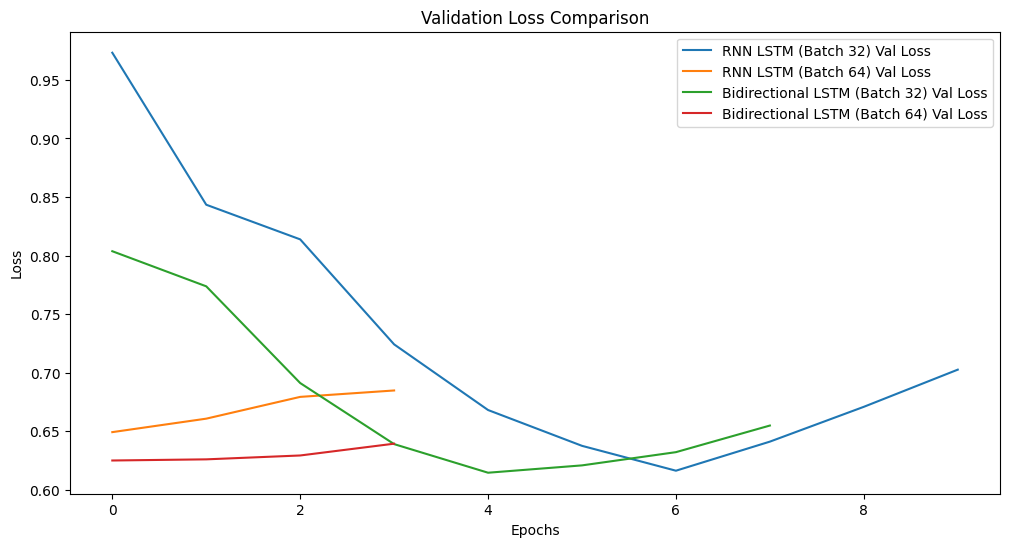

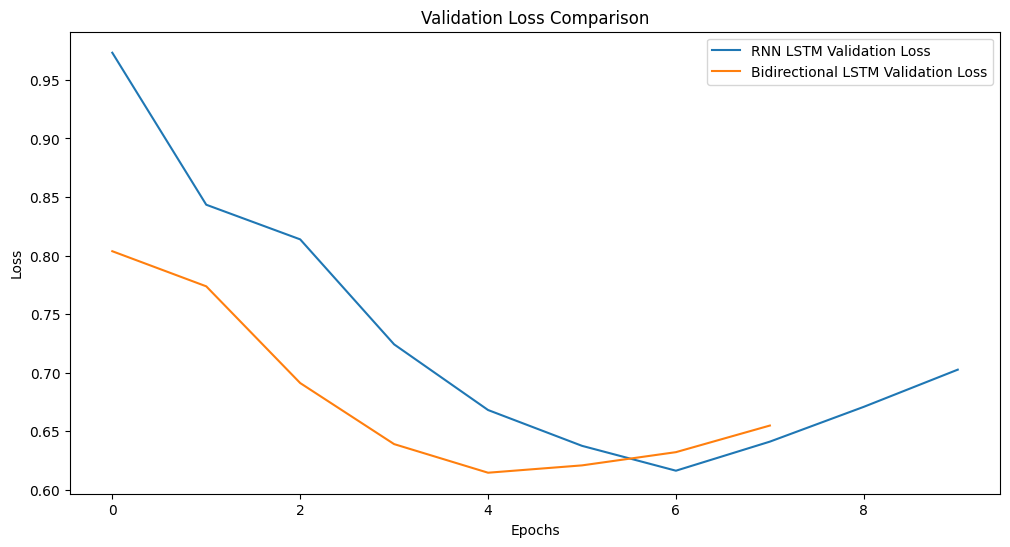

In [ ]:
# Plotting validation loss comparison
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['val_loss'], label='RNN LSTM (Batch 32) Val Loss')
plt.plot(history_lstm64.history['val_loss'], label='RNN LSTM (Batch 64) Val Loss')
plt.plot(history_bidirectional_lstm.history['val_loss'], label='Bidirectional LSTM (Batch 32) Val Loss')
plt.plot(history_bidirectional_lstm64.history['val_loss'], label='Bidirectional LSTM (Batch 64) Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.show()

# Loss comparison
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['val_loss'], label='RNN LSTM Validation Loss')
plt.plot(history_bidirectional_lstm.history['val_loss'], label='Bidirectional LSTM Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# Predict labels for test set
y_pred_lstm = model_lstm.predict(X_test).argmax(axis=1)
y_pred_bidirectional_lstm = model_bidirectional_lstm.predict(X_test).argmax(axis=1)

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report for RNN LSTM:\n", classification_report(y_test, y_pred_lstm))
print("Classification Report for Bidirectional LSTM RNN:\n", classification_report(y_test, y_pred_bidirectional_lstm))

332/332 [==============================] - 13s 37ms/step
Classification Report for RNN LSTM:
               precision    recall  f1-score   support

           0       0.80      0.79      0.79       779
           1       0.71      0.70      0.70       580
           2       0.76      0.69      0.72      3100
           3       0.91      0.93      0.92      3327
           4       0.51      0.40      0.45       248
           5       0.58      0.55      0.57       557
           6       0.64      0.76      0.70      2018

    accuracy                           0.77     10609
   macro avg       0.70      0.69      0.69     10609
weighted avg       0.77      0.77      0.77     10609

Classification Report for Bidirectional LSTM RNN:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       779
           1       0.75      0.67      0.71       580
           2       0.75      0.69      0.72      3100
           3       0.90      0.94      0.

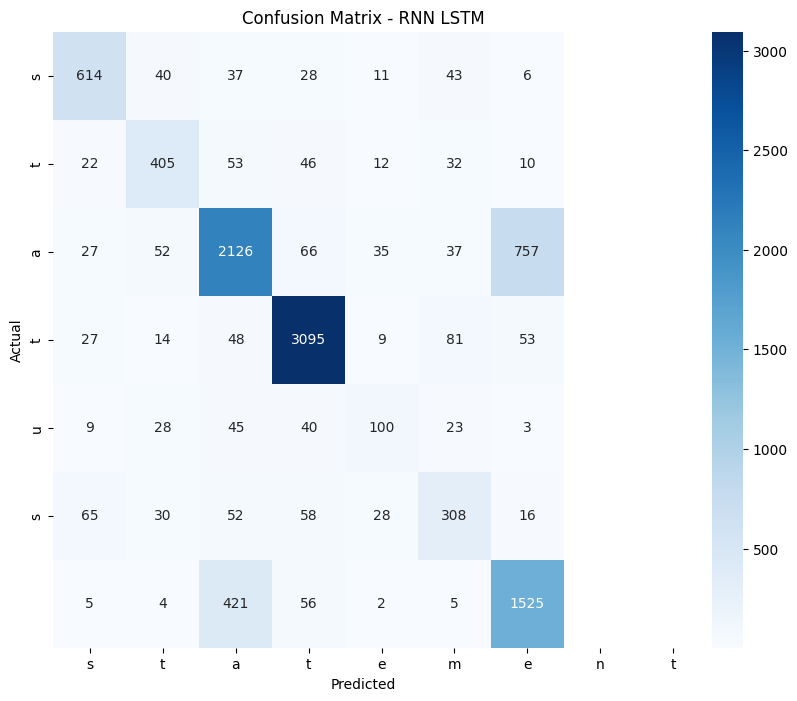

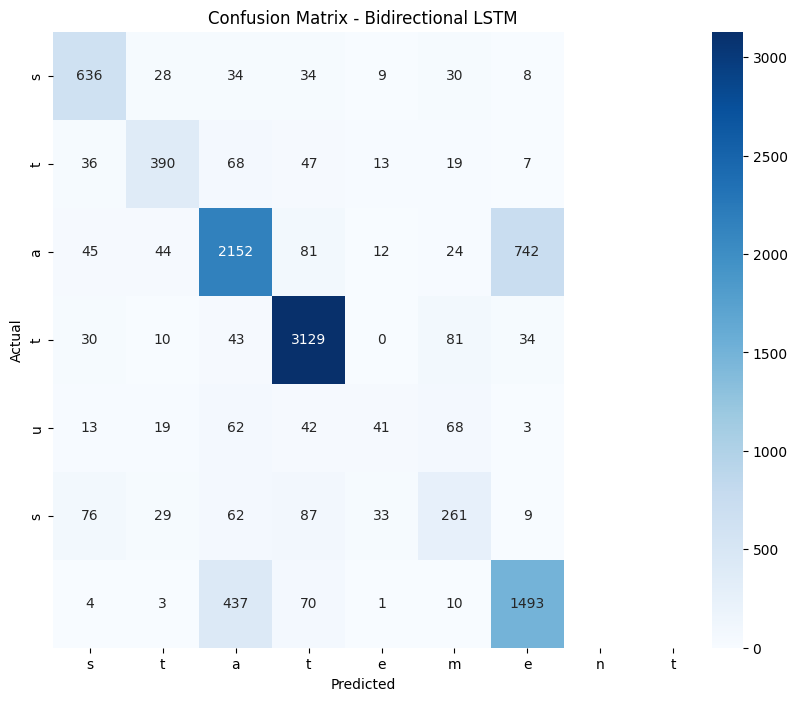

332/332 [==============================] - 13s 38ms/step
ROC-AUC Score for RNN LSTM: 0.9526348305398085
ROC-AUC Score for Bidirectional LSTM RNN: 0.9524806855367711


In [ ]:
# Confusion Matrix
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
conf_matrix_bidirectional = confusion_matrix(y_test, y_pred_bidirectional_lstm)

# Plot Confusion Matrix for LSTM
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', xticklabels='statement', yticklabels='status')
plt.title('Confusion Matrix - RNN LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot Confusion Matrix for Bidirectional LSTM
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_bidirectional, annot=True, fmt='d', cmap='Blues', xticklabels='statement', yticklabels='status')
plt.title('Confusion Matrix - Bidirectional LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate ROC-AUC Score (multi-class)
roc_auc_lstm = roc_auc_score(y_test, model_lstm.predict(X_test), multi_class='ovr')
roc_auc_bidirectional_lstm = roc_auc_score(y_test, model_bidirectional_lstm.predict(X_test), multi_class='ovr')
print("ROC-AUC Score for RNN LSTM:", roc_auc_lstm)
print("ROC-AUC Score for Bidirectional LSTM RNN:", roc_auc_bidirectional_lstm)
